In [1]:
%matplotlib inline
from __future__ import print_function, unicode_literals
import sys, os, glob
import re
import datetime as dt
import seaborn as sns
import json
import socket
from collections import OrderedDict

In [2]:
sys.path.append("../firedetection/")
from pygaarst import raster
import viirstools as vt
import viirsifire as vif

In [8]:
reload(vt)
reload(vif)

<module 'viirsifire' from 'viirsifire.pyc'>

In [3]:
import numpy as np
import matplotlib
import pygaarst
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

In [4]:
ALT1 = True
ALT2 = False 

basedir = '/Volumes/cwdata1/VIIRS/GINA/dds.gina.alaska.edu/NPP/viirs/'
if ALT1:
    basedir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/'
elif ALT2:
    basedir = '/Volumes/SCIENCE/Fire/DATA_BY_AREA/2015/VIIRS/'

if os.path.isdir(basedir):
    print(basedir, "exists")
else:
    print("Please check directory {}: cannot access it.".format(basedir))

/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/ exists


In [5]:
gisbasedir = "/Volumes/SCIENCE_mobile_Mac/GENERAL_GIS/"
firegisdir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/AICC/2015_FirePerimeters/"

In [53]:
viirsscenes = [
    (u'2015_07_06_187_2131', 2),
    (u'2015_07_06_187_2312', 0),
]

In [54]:
earth='cornsilk'
water='lightskyblue'

In [55]:
scenes = vt.getoverpasses(basedir, [scene[0] for scene in viirsscenes])
i04paths = [os.path.join(scenes[id]['dir'], scenes[id]['SVI04'][idx]) for id, idx in viirsscenes]
i05paths = [os.path.join(scenes[id]['dir'], scenes[id]['SVI05'][idx]) for id, idx in viirsscenes]
i03paths = [os.path.join(scenes[id]['dir'], scenes[id]['SVI03'][idx]) for id, idx in viirsscenes]
i02paths = [os.path.join(scenes[id]['dir'], scenes[id]['SVI02'][idx]) for id, idx in viirsscenes]
i01paths = [os.path.join(scenes[id]['dir'], scenes[id]['SVI01'][idx]) for id, idx in viirsscenes]

In [56]:
i04paths

[u'/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/2015_07_06_187_2131/sdr/SVI04_npp_d20150706_t2136198_e2137439_b19118_c20150706220143967785_cspp_dev.h5',
 u'/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/2015_07_06_187_2312/sdr/SVI04_npp_d20150706_t2314291_e2315533_b19119_c20150706233823431338_cspp_dev.h5']

In [57]:
#sample_lon, sample_lat = (-154.02015, 64.22526)
hughes_lon, hughes_lat = (-154.26, 66.04)
sample_lon, sample_lat = (-153.35, 65.8)
#sample_lon,sample_lat =  hughes_lon, hughes_lat
sceneidx = 0

In [58]:
railroads = os.path.join(gisbasedir, "matsugov.us/rr/railroad_latlon")
primaryroads = os.path.join(gisbasedir, "catalog.data.gov/tl_2013_02_prisecroads/tl_2013_02_prisecroads")
sideroads = os.path.join(gisbasedir, "matsugov.us/rds/rds_latlon")
fireperims = os.path.join(firegisdir, "FirePerimeters")
fairbanks_lon, fairbanks_lat = (-147.723056, 64.843611)

In [59]:
sns.set(rc={'image.cmap': 'gist_heat'})
#sns.set(rc={'image.cmap': 'magma'})
sns.set_context("poster")

myfontsize = 20
font = {'family' : 'Calibri',
        'weight': 'bold',
        'size'   : myfontsize}
matplotlib.rc('font', **font)
matplotlib.axes.rcParams['axes.labelsize']=myfontsize-4
matplotlib.axes.rcParams['axes.titlesize']=myfontsize
cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))


In [96]:
i04file = i04paths[sceneidx]
i05file = i05paths[sceneidx]

cbarfraction = 0.05
cbarpad = 0.05

testscene04 = raster.VIIRSHDF5(i04file)
testscene05 = raster.VIIRSHDF5(i05file)
#imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, 200, 300)
#imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, 50, 100)
imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, 20, 50)
print(
    testscene04.lats[testscene04.getnearestidx(sample_lat, sample_lon)], 
    testscene04.lons[testscene04.getnearestidx(sample_lat, sample_lon)]
)
print(sample_lat, sample_lon)
datestamp = vt.getdatestamp_AKDT(testscene04)
pixq4 = testscene04.pixelquality[imin:imax, jmin:jmax]
pixq5 = testscene05.pixelquality[imin:imax, jmin:jmax]
# find row indices where no data present
excluderows = np.where((pixq4[:, 0] == 2) | (pixq4[:, -1] == 2) )
pixq4 = np.delete(pixq4, excluderows, 0)
pixq5 = np.delete(pixq5, excluderows, 0)

65.7988 -153.348
65.8 -153.35


In [97]:
testscene04.meta

{u'Data_Product': {u'AggregateBeginningDate': u'20150706',
  u'AggregateBeginningGranuleID': u'NPP001168905804',
  u'AggregateBeginningOrbitNumber': u'19118',
  u'AggregateBeginningTime': u'213619.803439Z',
  u'AggregateEndingDate': u'20150706',
  u'AggregateEndingGranuleID': u'NPP001168905804',
  u'AggregateEndingOrbitNumber': u'19118',
  u'AggregateEndingTime': u'213743.979035Z',
  u'Instrument_Short_Name': u'VIIRS',
  u'N_Collection_Short_Name': u'VIIRS-I4-SDR',
  u'N_Dataset_Type_Tag': u'SDR',
  u'N_Processing_Domain': u'OPS'},
 u'Distributor': u'cspp',
 u'Mission_Name': u'NPP',
 u'N_Dataset_Source': u'all-',
 u'N_GEO_Ref': u'GITCO_npp_d20150706_t2136198_e2137439_b19118_c20150706220141848799_cspp_dev.h5',
 u'N_HDF_Creation_Date': u'20150706',
 u'N_HDF_Creation_Time': u'220143.967785Z',
 u'Number_of_Data_Products': u'1',
 u'Platform_Short_Name': u'NPP'}

In [98]:
rasterlist = []

In [99]:
excluderows

(array([], dtype=int64),)

## Calculate indices to skip b/c of duplicate locations

In [100]:
import viirsswathtools as vst

In [101]:
skips = vst.get_skips(testscene04, imin=imin, imax=imax, jmin=jmin, jmax=jmax)

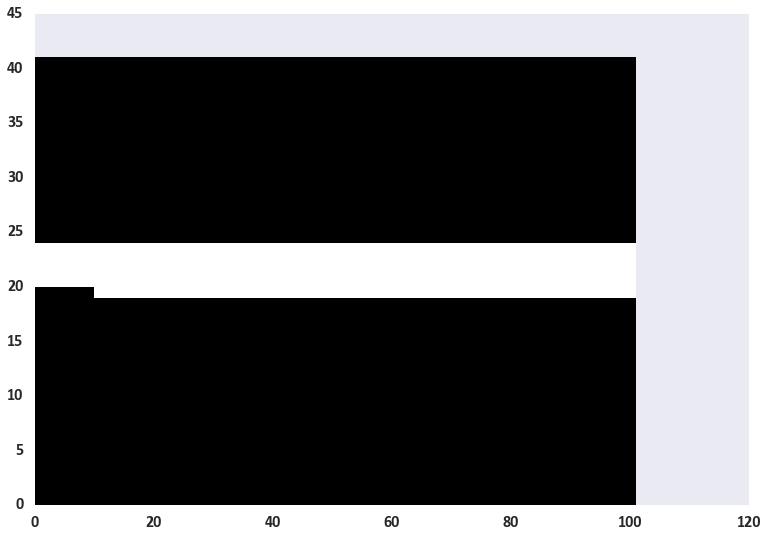

In [102]:
plt.pcolormesh(skips)

## Make plots of bands

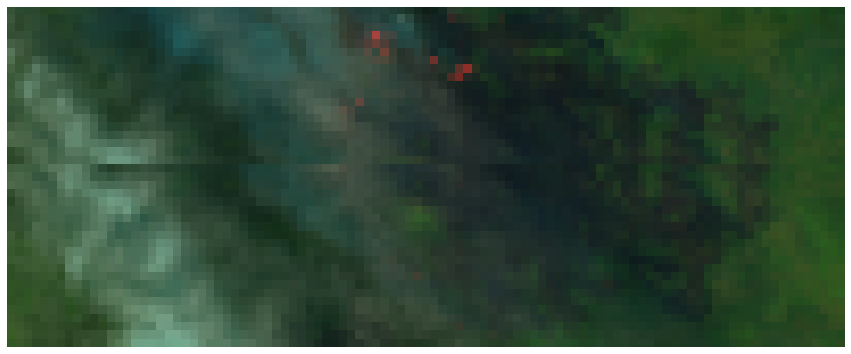

In [103]:
# zeroth plot: visible RGB, just for fun
SAVEFIG = False

plotrasters = []
for datapath in [i03paths, i02paths, i01paths]:
    scene = raster.VIIRSHDF5(datapath[sceneidx])
    bandname = scene.bandname
    testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
    mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
    plotraster = np.fliplr(testdat*mult + add)
    plotraster = np.delete(plotraster, excluderows, 0)
    plotrasters.append(plotraster)

rgbraster = np.dstack(plotrasters)
    
fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
#dataplot = ax1.imshow(np.flipud(plotraster) , interpolation='nearest', cmap='bone')
dataplot = ax1.imshow(np.flipud(rgbraster), interpolation='nearest')
#ax1.set_title('Western Alaska: Overview plot from band {}, {}'.format(
#        scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp))
if SAVEFIG:
    datestamp = vt.getdatestamp_AKDT(scene, spaces=False)
    outdir = '/Users/cwaigl/Dropbox/Research/PhD/2015VIRSPaper/NorthernYK/'
    outfn = 'VIIRSRGB_{}.pdf'.format(datestamp)
    plt.savefig(os.path.join(outdir, outfn), bbox_inches='tight', dpi=400)
plt.show()

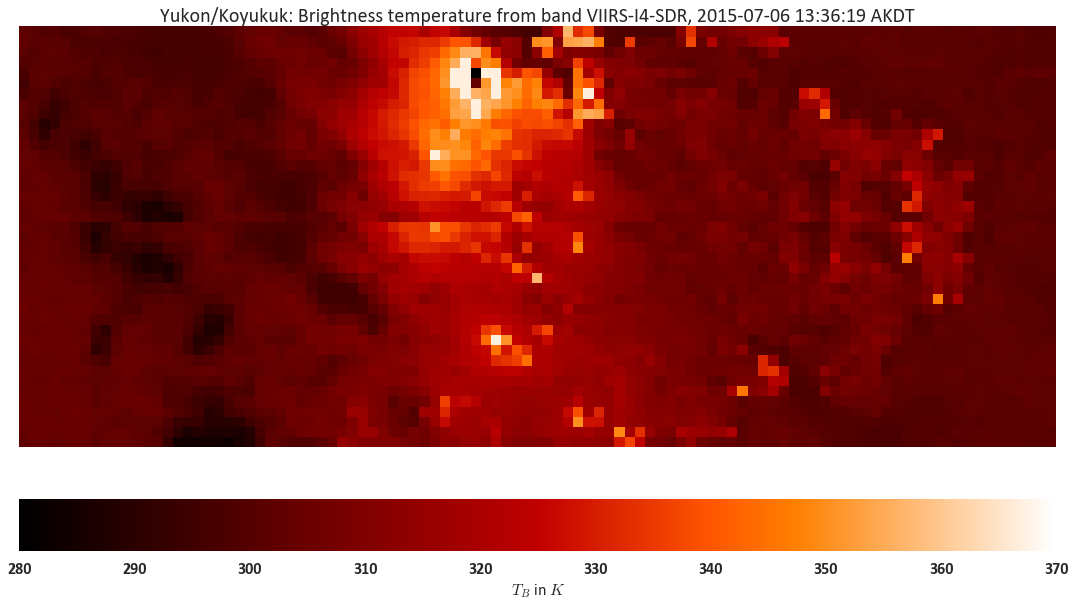

In [104]:
# first plot
SAVEFIG = False

scene = testscene04
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]

#plotraster = np.fliplr(testdat*mult + add)
#plotraster = np.delete(plotraster, excluderows, 0)
#rasterlist.append(plotraster)

testdat = testdat*mult + add
testdat = np.delete(testdat, excluderows, 0)
rasterlist.append(testdat)
plotraster = np.fliplr(testdat)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
#dataplot = ax1.imshow(np.flipud(plotraster) , interpolation='nearest', vmin=280, vmax=370)
dataplot = ax1.pcolormesh(plotraster, vmin=280, vmax=370)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("$T_B$ in $K$")
datestamp = vt.getdatestamp_AKDT(scene)
ax1.set_title('Yukon/Koyukuk: Brightness temperature from band {}, {}'.format(
        scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp))
plt.show()
if SAVEFIG:
    datestamp = vt.getdatestamp_AKDT(scene, spaces=False)
    outdir = '/Users/cwaigl/Dropbox/Research/PhD/2015VIRSPaper/NorthernYK/'
    outfn = 'YK_VIIRS-I_{}_{}.png'.format(scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp)
    fig1.savefig(os.path.join(outdir, outfn), bbox_inches='tight', dpi=200)
    plt.close()

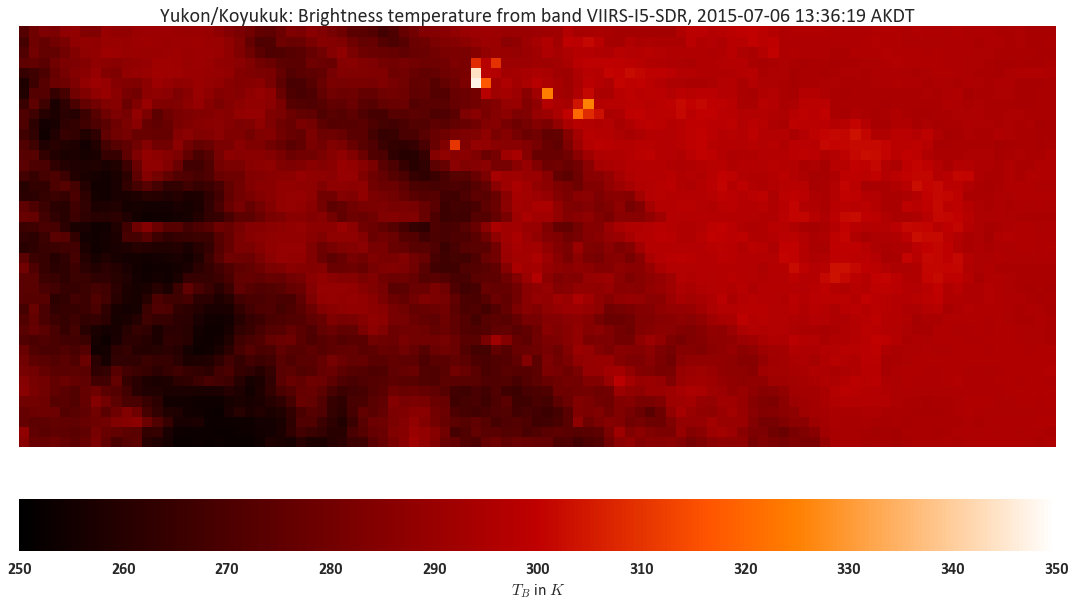

In [105]:
# second plot
SAVEFIG = True
scene = testscene05
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]

testdat = testdat*mult + add
testdat = np.delete(testdat, excluderows, 0)
rasterlist.append(testdat)
plotraster = np.fliplr(testdat)

plotraster_river = np.ma.masked_where(plotraster <= 295, np.ones(plotraster.shape))

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
dataplot = ax1.imshow(np.flipud(plotraster) , interpolation='nearest', vmin=280, vmax=370)
dataplot = ax1.pcolormesh(plotraster, vmin=250, vmax=350)
#conplot = ax1.contour(plotraster, colors='k')
plt.clabel(conplot, fontsize=9, inline=1)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("$T_B$ in $K$")
ax1.set_title('Yukon/Koyukuk: Brightness temperature from band {}, {}'.format(
        scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp))
plt.show()
if SAVEFIG:
    datestamp = vt.getdatestamp_AKDT(scene, spaces=False)
    outdir = '/Users/cwaigl/Dropbox/Research/PhD/2015VIRSPaper/NorthernYK/'
    outfn = 'YK_VIIRS-I_{}_{}.png'.format(scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp)
    fig1.savefig(os.path.join(outdir, outfn), bbox_inches='tight', dpi=200)
    plt.close()

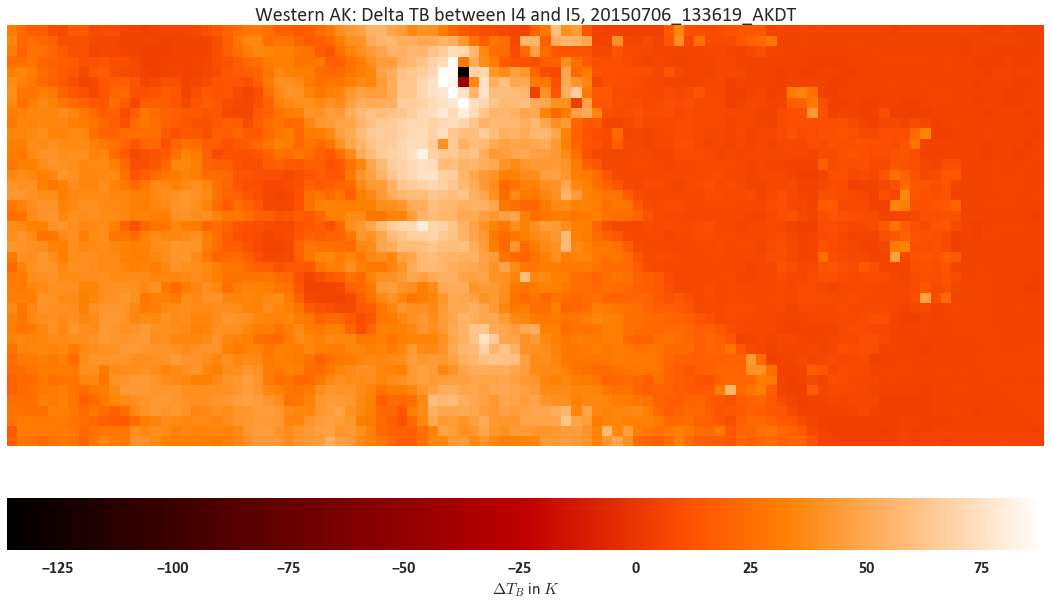

In [106]:
# third plot
plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  plotraster4 - plotraster5
plotraster45_masked = np.ma.masked_where(
    np.logical_and(plotraster45 <= 30, np.logical_or(
            pixq4 < 9, plotraster4 < 360)), np.ones(plotraster45.shape))
plotraster_cool = np.ma.masked_where(
    np.logical_or(plotraster45 <= 12, plotraster5 < 297), np.ones(plotraster45.shape))

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
dataplot = ax1.pcolormesh(np.fliplr(plotraster45))
#dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
#dataplot2 = ax1.pcolormesh(plotraster45_masked, vmin=0, vmax=1)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("$\Delta T_B$ in $K$")
ax1.set_title('Western AK: Delta TB between I4 and I5, {}'.format(datestamp))
plt.show()

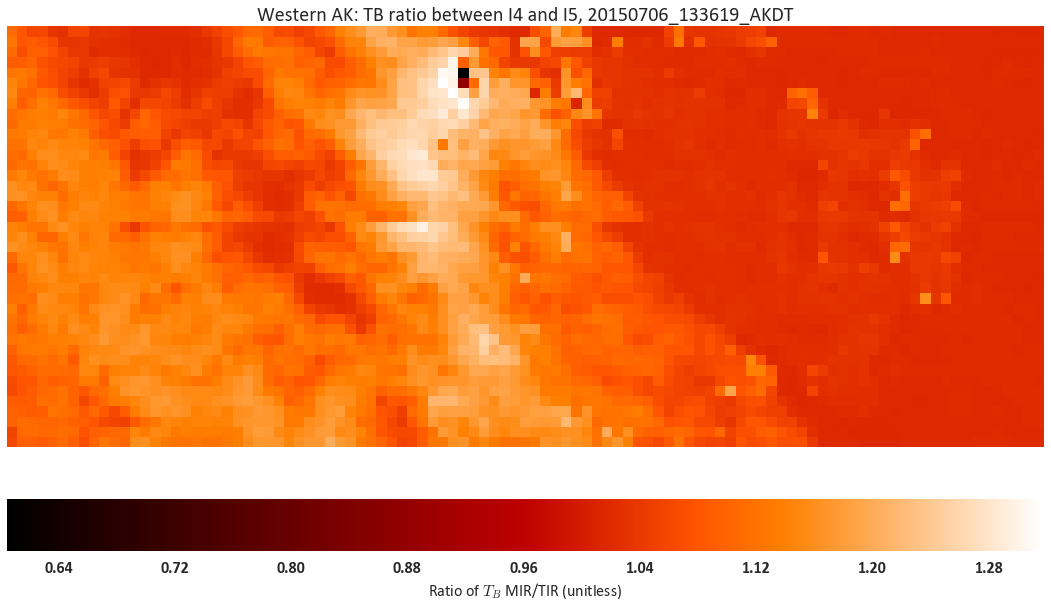

In [107]:
# fourth plot: ratio
plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  plotraster4 / plotraster5

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
dataplot = ax1.pcolormesh(np.fliplr(plotraster45))
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("Ratio of $T_B$ MIR/TIR (unitless)")
ax1.set_title('Western AK: TB ratio between I4 and I5, {}'.format(datestamp))
plt.show()


In [124]:
reload(vif)

<module 'viirsifire' from '../firedetection/viirsifire.py'>

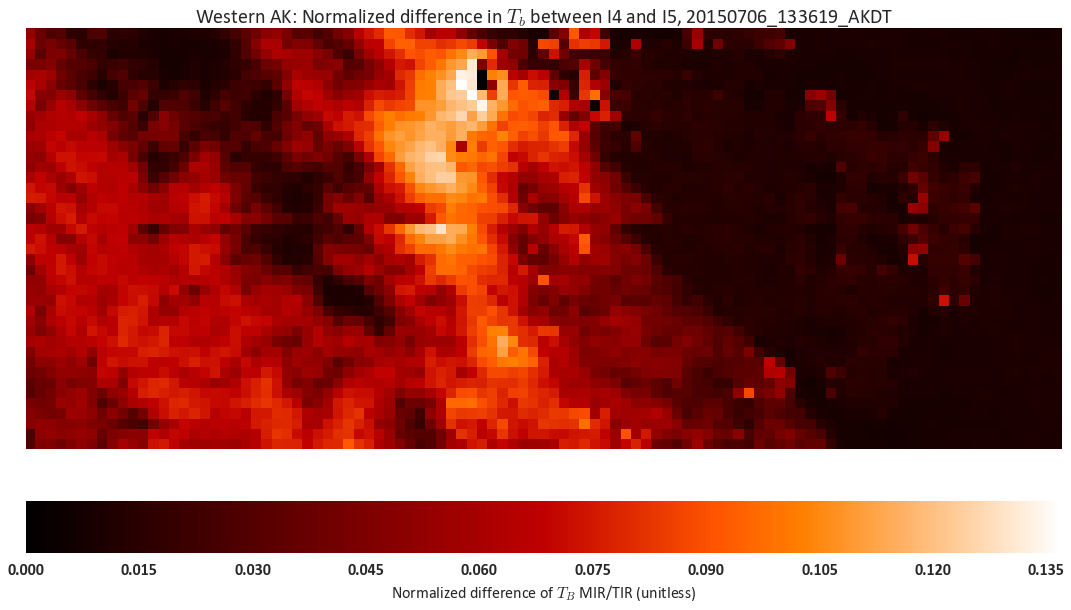

In [126]:
# fifth plot: normalized difference 
MASK = False

scene = raster.VIIRSHDF5(i01paths[sceneidx])
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster1 = testdat*mult + add
plotraster1 = np.delete(plotraster1, excluderows, 0)

scene = raster.VIIRSHDF5(i02paths[sceneidx])
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster2 = testdat*mult + add
plotraster2 = np.delete(plotraster2, excluderows, 0)


plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)

if MASK:
    anomalouscondition, hotcondition, warmcondition = vif.getfireconditions_fromrasters(
        plotraster4, plotraster5, pixq4, pixq5)
    hotcondition = np.logical_or(hotcondition, anomalouscondition)
    cloudcondition = np.logical_or(
        plotraster5 < 270, 
        np.logical_and(plotraster1 + plotraster2 > 0.9, plotraster5 < 295))
    cloudcondition = np.logical_or(
        cloudcondition,
        np.logical_and(plotraster1 + plotraster2 > 0.7, plotraster5 < 285),)
    cloudmask = np.ma.masked_where(
        ~cloudcondition, np.ones(plotraster5.shape))

    plotraster45_masked = np.ma.masked_where(~hotcondition, np.ones(plotraster45.shape))
    plotraster_cool = np.ma.masked_where(
        ~warmcondition, np.ones(plotraster45.shape))
    cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
    cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))
    cmap4 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'turquoise']))

    plottitle = 'Western AK: Normalized difference in $T_b$ between I4 and I5, {}\n high intensity fire pixels in bright yellow, low intensity in purple'.format(datestamp)
else:
    plottitle = 'Western AK: Normalized difference in $T_b$ between I4 and I5, {}'.format(datestamp)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
dataplot = ax1.pcolormesh(np.fliplr(plotraster45), vmin=0)    
if MASK:
    dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
    dataplot2 = ax1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
    cloudplot = ax1.pcolormesh(np.fliplr(cloudmask), cmap=cmap4, alpha=0.5, vmin=0, vmax=1)
ax1.set_title(plottitle)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("Normalized difference of $T_B$ MIR/TIR (unitless)")
plt.show()


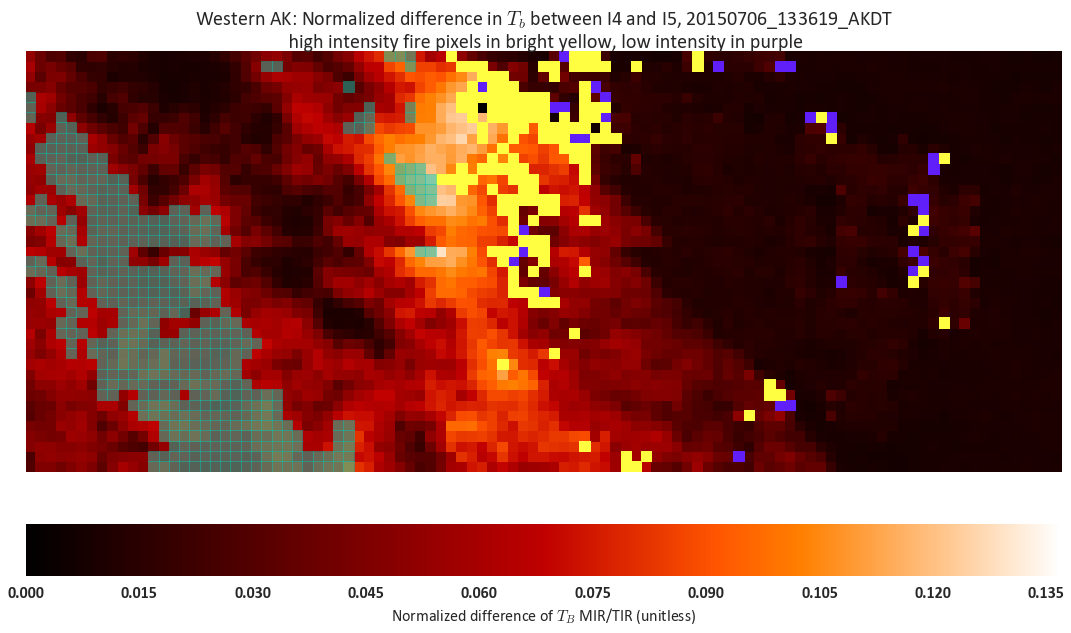

In [128]:
# fifth plot: normalized difference 
MASK = True

scene = raster.VIIRSHDF5(i01paths[sceneidx])
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster1 = testdat*mult + add
plotraster1 = np.delete(plotraster1, excluderows, 0)

scene = raster.VIIRSHDF5(i02paths[sceneidx])
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster2 = testdat*mult + add
plotraster2 = np.delete(plotraster2, excluderows, 0)


plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)

if MASK:
    anomalouscondition, hotcondition, warmcondition = vif.getfireconditions_fromrasters(
        plotraster4, plotraster5, pixq4, pixq5)
    hotcondition = np.logical_or(hotcondition, anomalouscondition)
    cloudcondition = np.logical_or(
        plotraster5 < 265, 
        np.logical_and(plotraster1 + plotraster2 > 0.9, plotraster5 < 295))
    cloudcondition = np.logical_or(
        cloudcondition,
        np.logical_and(plotraster1 + plotraster2 > 0.7, plotraster5 < 285),)
    cloudmask = np.ma.masked_where(
        ~cloudcondition, np.ones(plotraster5.shape))

    plotraster45_masked = np.ma.masked_where(~hotcondition, np.ones(plotraster45.shape))
    plotraster_cool = np.ma.masked_where(
        ~warmcondition, np.ones(plotraster45.shape))
    cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
    cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))
    cmap4 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'turquoise']))

    plottitle = 'Western AK: Normalized difference in $T_b$ between I4 and I5, {}\n high intensity fire pixels in bright yellow, low intensity in purple'.format(datestamp)
else:
    plottitle = 'Western AK: Normalized difference in $T_b$ between I4 and I5, {}'.format(datestamp)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
dataplot = ax1.pcolormesh(np.fliplr(plotraster45), vmin=0)    
if MASK:
    dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
    dataplot2 = ax1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
    cloudplot = ax1.pcolormesh(np.fliplr(cloudmask), cmap=cmap4, alpha=0.5, vmin=0, vmax=1)
ax1.set_title(plottitle)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("Normalized difference of $T_B$ MIR/TIR (unitless)")
plt.show()

## Investigate anomalies

Let's look in band 4 first.

In [32]:
y = np.bincount(pixq4.ravel())
vals = np.nonzero(y)[0]
zip(vals, y[vals])

[(0, 209680), (9, 48), (193, 21)]

In [33]:
for ii in vals:
    print("{0:b}".format(ii))
    print(np.where(pixq4 == ii))

0
(array([  0,   0,   0, ..., 348, 348, 348]), array([  0,   1,   2, ..., 598, 599, 600]))
1001
(array([ 31,  63,  63,  93, 106, 106, 110, 112, 116, 117, 117, 118, 166,
       180, 184, 185, 186, 186, 186, 187, 187, 187, 188, 188, 188, 188,
       189, 193, 197, 200, 210, 219, 226, 255, 261, 263, 267, 268, 275,
       279, 279, 284, 292, 295, 295, 295, 298, 301]), array([259, 122, 123, 236, 523, 524, 116, 129, 133, 122, 126, 123, 304,
       310, 306, 306, 295, 304, 307, 304, 307, 308, 304, 305, 307, 308,
       307, 246, 247, 269, 232, 270, 254, 342, 346, 345, 345, 345, 323,
       332, 334, 376, 376, 366, 367, 372, 370, 376]))
11000001
(array([188, 263, 264, 272, 272, 273, 296, 297, 297, 297, 298, 298, 298,
       299, 299, 299, 299, 300, 300, 300, 301]), array([306, 346, 347, 337, 338, 338, 369, 369, 371, 375, 373, 375, 378,
       372, 373, 374, 375, 373, 374, 375, 374]))


In [34]:
y = np.bincount(pixq5.ravel())
vals = np.nonzero(y)[0]
zip(vals, y[vals])

[(0, 209746), (65, 3)]

In [35]:
print(plotraster4[np.where(pixq5 == 65)])
print(plotraster5[np.where(pixq5 == 65)])
print(pixq4[np.where(pixq5 == 65)])

[ 208.          208.          253.32180786]
[ 365.16320801  365.85467529  358.97509766]
[193 193   0]


In [36]:
print(plotraster4[np.where(pixq4 == 193)])
print(plotraster5[np.where(pixq4 == 193)])
print(pixq5[np.where(pixq4 == 193)])

[ 208.  208.  208.  208.  208.  208.  208.  208.  208.  208.  208.  208.
  208.  208.  208.  208.  208.  208.  208.  208.  208.]
[ 343.91717529  330.5335083   343.6293335   354.64373779  365.16320801
  319.87713623  349.58581543  342.37628174  329.29449463  365.85467529
  347.4342041   354.76660156  330.4352417   325.23693848  322.52017212
  326.34606934  333.01159668  333.32397461  321.97262573  330.92312622
  307.50787354]
[ 0  0  0  0 65  0  0  0  0 65  0  0  0  0  0  0  0  0  0  0  0]


In [37]:
print(np.max(plotraster4), np.max(plotraster5))
print(plotraster4.shape, plotraster5.shape, pixq4.shape, pixq5.shape)

367.0 365.855
(349, 601) (349, 601) (349, 601) (349, 601)


In [38]:
print(plotraster4[np.where(pixq4 == 9)])
print(plotraster5[np.where(pixq4 == 9)])
print(pixq5[np.where(pixq4 == 9)])

[ 367.  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.
  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.
  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.
  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.  367.]
[ 299.11196899  310.42471313  310.09124756  304.69638062  297.38153076
  308.65216064  301.67077637  305.49664307  306.40222168  306.3215332
  307.62371826  305.88275146  291.49176025  284.72094727  286.30749512
  280.25622559  301.26708984  291.62512207  278.48016357  291.82870483
  282.44998169  278.76446533  296.57073975  298.3046875   281.70233154
  280.8213501   281.94104004  300.78271484  306.34606934  305.22290039
  301.34783936  304.14880371  301.96911621  298.79608154  303.54510498
  299.88415527  309.45947266  308.38189697  301.39346313  302.52722168
  299.91223145  296.10388184  299.32608032  303.0501709   306.11791992
  302.43945312  292.16564941  279.49102783]
[0 0 0 0 0 0 0 0 0 0 0 0 

In [39]:
print(pixq4[np.where(plotraster4 == 367.0)])
print(pixq5[np.where(plotraster5 > 365)])

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9]
[65 65]


In [40]:
bounds = np.append(vals, [255])

In [41]:
print((bounds[1:] + bounds[:-1])/2)


[ 32 160]


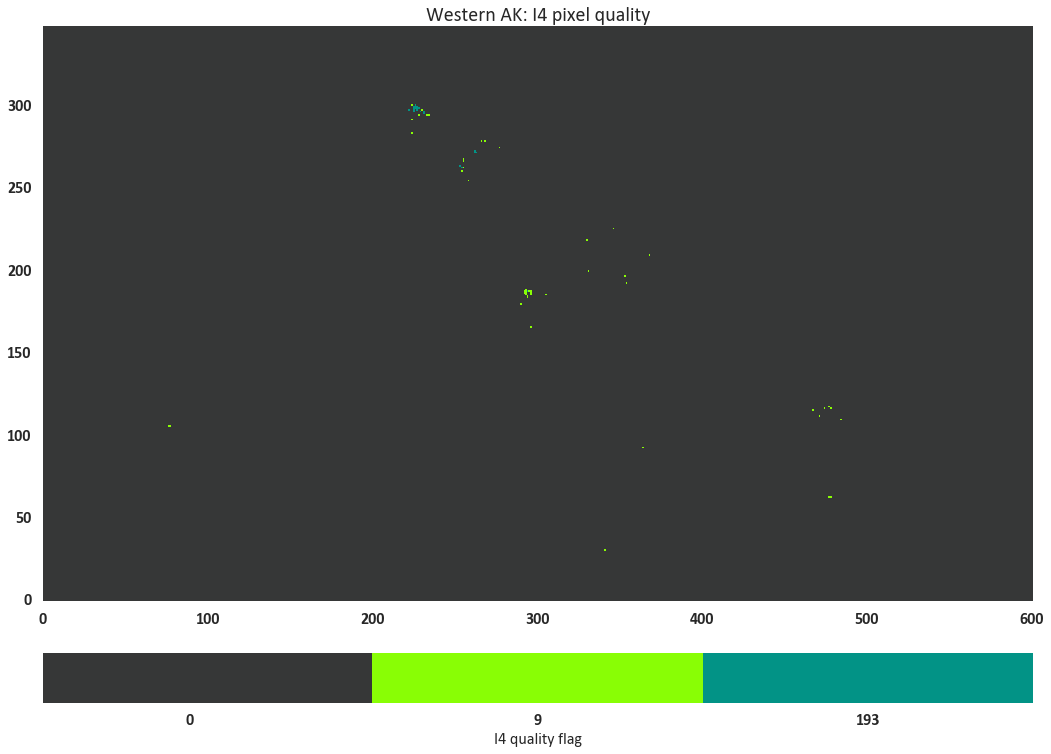

In [42]:
# fifth plot: quality raster 

#cmap_husl = matplotlib.colors.ListedColormap(sns.color_palette("husl", 256))
cmap_qflag =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['dark grey', 'lime green', 'teal']))

y = np.bincount(pixq4.ravel())
vals = np.nonzero(y)[0]
qflagbounds = np.append(vals, [255])
qflagnorm = matplotlib.colors.BoundaryNorm(qflagbounds, cmap_qflag.N)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
#ax1.grid(False)
#dataplot = ax1.imshow(np.flipud(pixq4), interpolation='nearest', cmap=cmap_qflag, norm=qflagnorm)
dataplot = ax1.pcolormesh(
    np.fliplr(pixq4), 
    cmap=cmap_qflag, norm=qflagnorm)
ax1.set_aspect('equal')
ax1.set_xlim(0, pixq5.shape[1])
ax1.set_ylim(0, pixq5.shape[0])
plt.tight_layout()

cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("I4 quality flag")
labels = vals
loc = (qflagbounds[1:] + qflagbounds[:-1])/2
cbar.set_ticks(loc)
cbar.set_ticklabels(labels)
ax1.set_title('Western AK: I4 pixel quality'.format(datestamp))
plt.show()

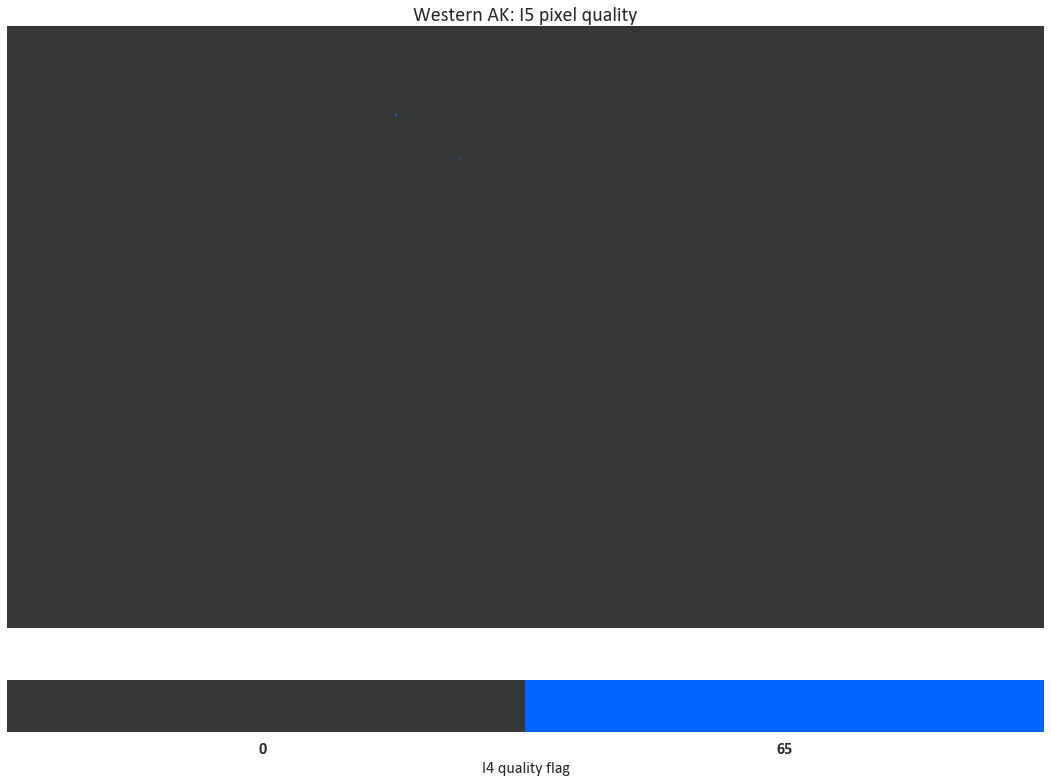

In [43]:
# sixth plot: I5 quality raster 

cmap_qflag =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['dark grey', 'bright blue']))
y = np.bincount(pixq5.ravel())
vals = np.nonzero(y)[0]
qflagbounds = np.append(vals, [255])
qflagnorm = matplotlib.colors.BoundaryNorm(qflagbounds, cmap_qflag.N)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)
dataplot = ax1.pcolormesh(
    np.fliplr(pixq5), 
    cmap=cmap_qflag, norm=qflagnorm)
ax1.set_aspect('equal')
ax1.set_xlim(0, pixq5.shape[1])
ax1.set_ylim(0, pixq5.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("I4 quality flag")
labels = vals
loc = (qflagbounds[1:] + qflagbounds[:-1])/2
cbar.set_ticks(loc)
cbar.set_ticklabels(labels)
ax1.set_title('Western AK: I5 pixel quality'.format(datestamp))
plt.show()

In [44]:
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from shapely.geometry import box

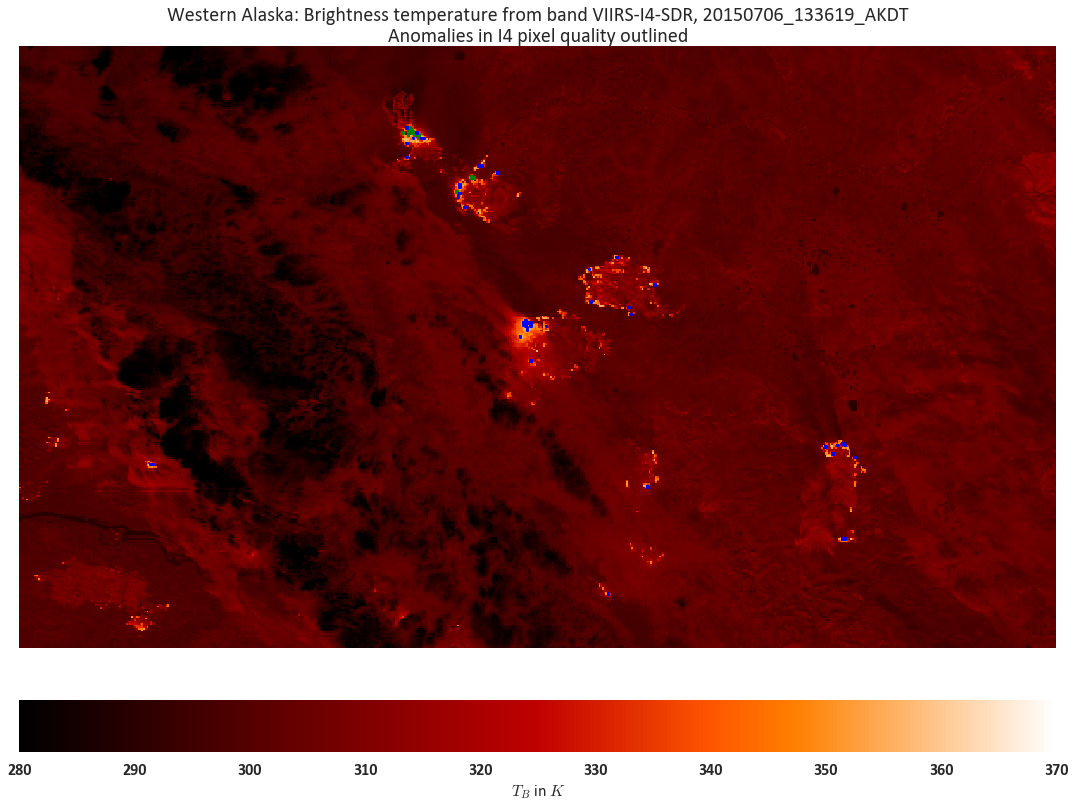

In [45]:
# plot of T4 with anomalous pixels marked
scene = testscene04
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]

testdat = testdat*mult + add
testdat = np.delete(testdat, excluderows, 0)
plotraster = np.fliplr(testdat)

cmap4_9 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'lime green']))
cmap4_193 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'teal']))
cmap5_65 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'bright blue']))
q4cond_9 = (pixq4 == 9)
q4cond_193 = (pixq4 == 193)
q5cond_65 = (pixq5 == 65)
q4_9_masked = np.ma.masked_where(~q4cond_9, np.ones(plotraster.shape))
q4_193_masked = np.ma.masked_where(~q4cond_193, np.ones(plotraster.shape))
q5_65_masked = np.ma.masked_where(~q5cond_65, np.ones(plotraster.shape))


fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
#dataplot = ax1.imshow(np.flipud(plotraster) , interpolation='nearest', vmin=280, vmax=370)
dataplot = ax1.pcolormesh(plotraster, vmin=280, vmax=370)
#dataplotq4_9 = ax1.pcolormesh(np.fliplr(q4_9_masked), cmap=cmap4_9, vmin=0, vmax=1)
#dataplotq4_193 = ax1.pcolormesh(np.fliplr(q4_193_masked), cmap=cmap4_193, vmin=0, vmax=1)
#dataplotq5_65 = ax1.pcolormesh(np.fliplr(q5_65_masked), cmap=cmap5_65, alpha=.2, vmin=0, vmax=1)
iis, jjs =  np.where(np.fliplr(pixq4) == 193)
for ii, jj in zip(iis, jjs):
    y, x = box(ii, jj, ii+1, jj+1).boundary.xy
    ax1.plot(x, y, color='green', linewidth=2, zorder=5)
iis, jjs =  np.where(np.fliplr(pixq4) == 9)
for ii, jj in zip(iis, jjs):
    y, x = box(ii, jj, ii+1, jj+1).boundary.xy
    ax1.plot(x, y, color='blue', linewidth=2, zorder=5)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("$T_B$ in $K$")
ax1.set_title('Western Alaska: Brightness temperature from band {}, {}\nAnomalies in I4 pixel quality outlined'.format(
        scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp))
plt.savefig("testfires")
plt.show()

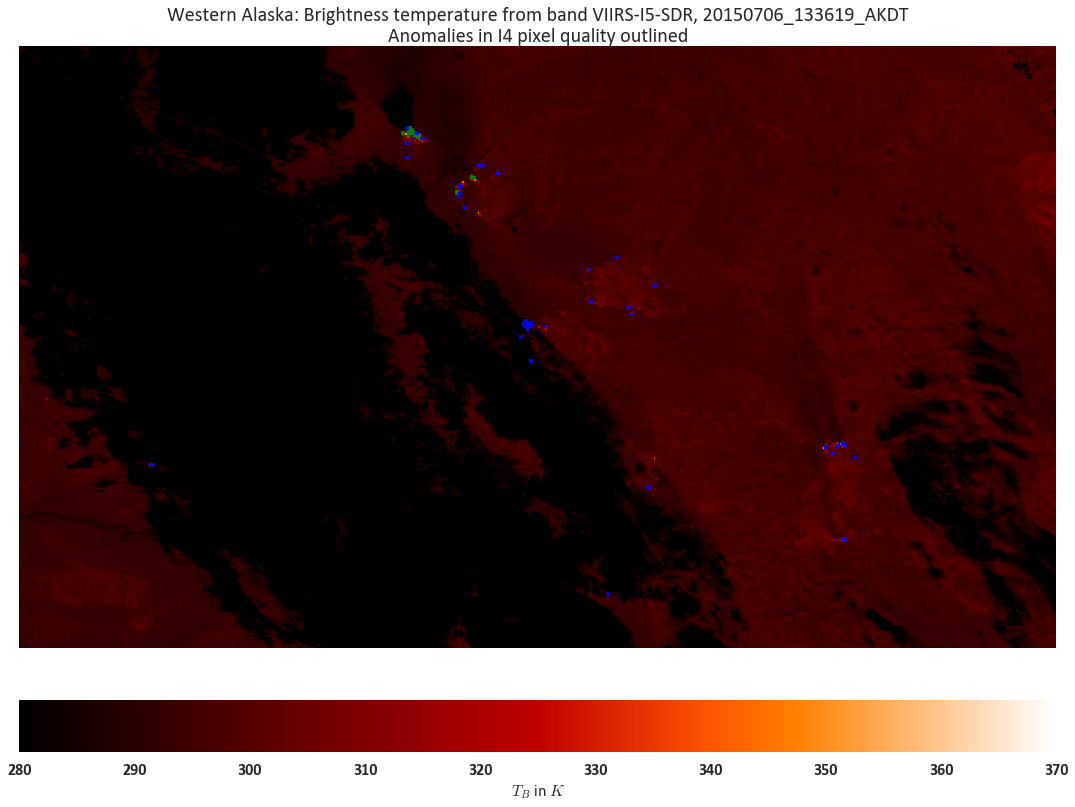

In [46]:
# second plot
scene = testscene05
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]

testdat = testdat*mult + add
testdat = np.delete(testdat, excluderows, 0)
rasterlist.append(testdat)
plotraster = np.fliplr(testdat)

plotraster_river = np.ma.masked_where(plotraster <= 295, np.ones(plotraster.shape))

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
#dataplot = ax1.imshow(np.flipud(plotraster) , interpolation='nearest', vmin=280, vmax=370)
dataplot = ax1.pcolormesh(plotraster, vmin=280, vmax=370)
iis, jjs =  np.where(np.fliplr(pixq4) == 193)
for ii, jj in zip(iis, jjs):
    y, x = box(ii, jj, ii+1, jj+1).boundary.xy
    ax1.plot(x, y, color='green', linewidth=2, zorder=5)
iis, jjs =  np.where(np.fliplr(pixq4) == 9)
for ii, jj in zip(iis, jjs):
    y, x = box(ii, jj, ii+1, jj+1).boundary.xy
    ax1.plot(x, y, color='blue', linewidth=2, zorder=5)


ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("$T_B$ in $K$")
ax1.set_title('Western Alaska: Brightness temperature from band {}, {}\nAnomalies in I4 pixel quality outlined'.format(
        scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp))
plt.show()

In [47]:
iis, jjs =  np.where(pixq4 == 9)
zip(iis, jjs)

[(31, 259),
 (63, 122),
 (63, 123),
 (93, 236),
 (106, 523),
 (106, 524),
 (110, 116),
 (112, 129),
 (116, 133),
 (117, 122),
 (117, 126),
 (118, 123),
 (166, 304),
 (180, 310),
 (184, 306),
 (185, 306),
 (186, 295),
 (186, 304),
 (186, 307),
 (187, 304),
 (187, 307),
 (187, 308),
 (188, 304),
 (188, 305),
 (188, 307),
 (188, 308),
 (189, 307),
 (193, 246),
 (197, 247),
 (200, 269),
 (210, 232),
 (219, 270),
 (226, 254),
 (255, 342),
 (261, 346),
 (263, 345),
 (267, 345),
 (268, 345),
 (275, 323),
 (279, 332),
 (279, 334),
 (284, 376),
 (292, 376),
 (295, 366),
 (295, 367),
 (295, 372),
 (298, 370),
 (301, 376)]

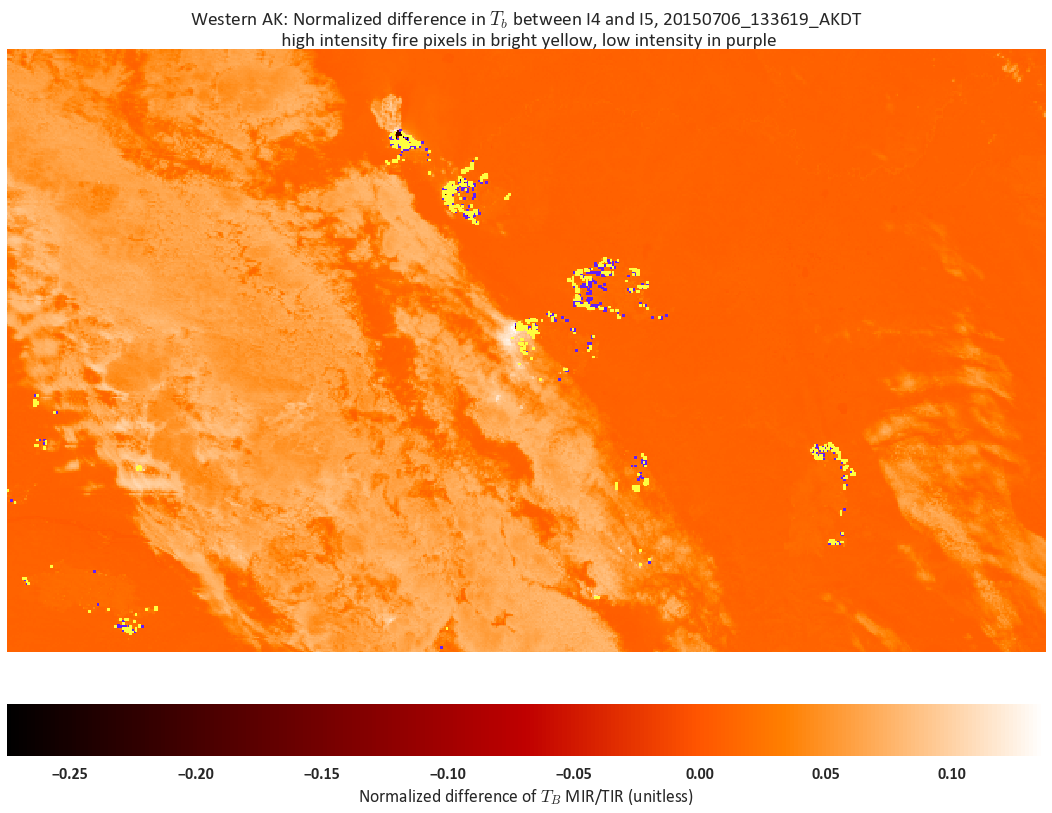

In [68]:
# sith plot: normalized difference 
MASK = True

plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)

if MASK:
    hotcondition = np.logical_or(plotraster45 >= 0.05, np.logical_and(pixq4 == 9, plotraster4 < 360))
    hotcondition = np.logical_and(np.logical_and(hotcondition, plotraster4 > 320), plotraster5 > 290)
    plotraster45_masked = np.ma.masked_where(~hotcondition, np.ones(plotraster45.shape))
    warmcondition = np.logical_or(plotraster45 >= 0.02, np.logical_and(plotraster45 >= 0.015, plotraster5>=308))
    warmcondition = np.logical_and(np.logical_and(warmcondition, plotraster4 > 320), plotraster5 > 290)
    plotraster_cool = np.ma.masked_where(
        ~warmcondition, np.ones(plotraster45.shape))
    cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
    cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))
    plottitle = 'Western AK: Normalized difference in $T_b$ between I4 and I5, {}\n high intensity fire pixels in bright yellow, low intensity in purple'.format(datestamp)
else:
    plottitle = 'Western AK: Normalized difference in $T_b$ between I4 and I5, {}'.format(datestamp)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
dataplot = ax1.pcolormesh(np.fliplr(plotraster45))    
if MASK:
    dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
    dataplot2 = ax1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
ax1.set_title(plottitle)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("Normalized difference of $T_B$ MIR/TIR (unitless)")
plt.show()


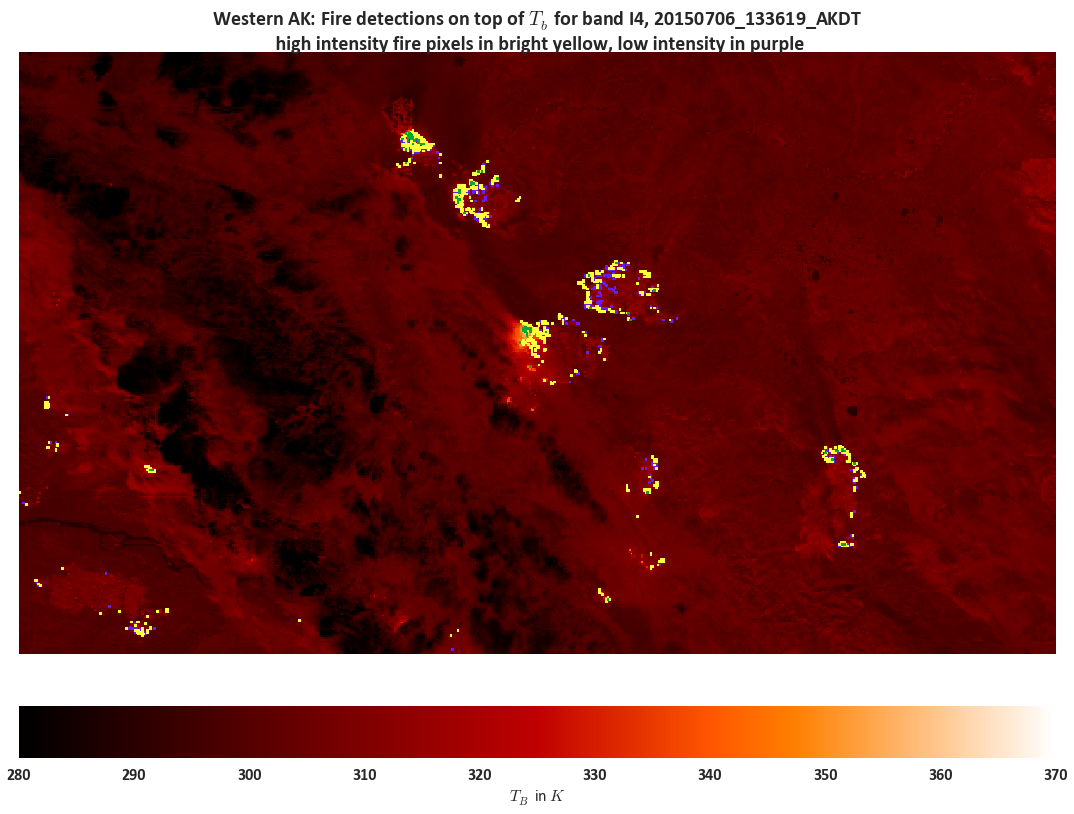

In [41]:
# masks on top of 4 micrometer band

plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)
i4tb = plotraster4
i5tb = plotraster5
i45 = plotraster45

anomalouscondition, hotcondition, warmcondition = vif.getfireconditions_fromrasters(
        plotraster4, plotraster5, pixq4, pixq5)

plotraster45_masked = np.ma.masked_where(~hotcondition, np.ones(plotraster45.shape))
plotraster_cool = np.ma.masked_where(
    ~warmcondition, np.ones(plotraster45.shape))
plotraster45_anomalousmasked = np.ma.masked_where(
    ~anomalouscondition, np.ones(plotraster45.shape))

cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))
cmap3 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'kelly green']))

plottitle = 'Western AK: Fire detections on top of $T_b$ for band I4, {}\n high intensity fire pixels in bright yellow, low intensity in purple'.format(datestamp)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

dataplot = ax1.pcolormesh(np.fliplr(plotraster4), vmin=280, vmax=370)    
dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
dataplot2 = ax1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
dataplot1 = ax1.pcolormesh(np.fliplr(plotraster45_anomalousmasked), cmap=cmap3, vmin=0, vmax=1)
ax1.set_title(plottitle)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()

cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("$T_B$ in $K$")
plt.show()


## Now we plot on maps

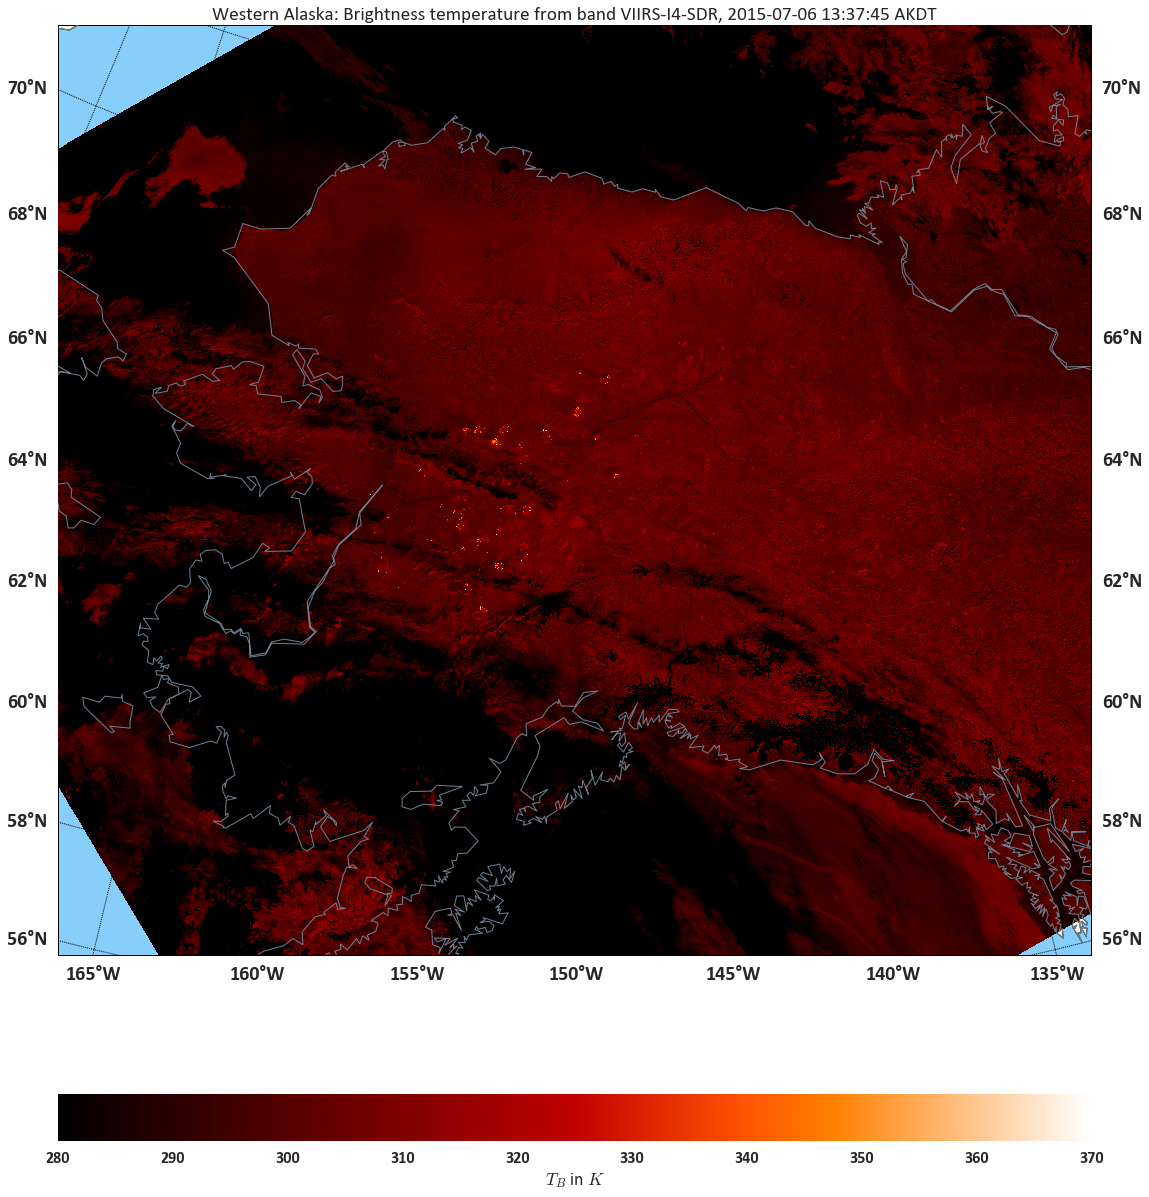

In [173]:
scenelist = [raster.VIIRSHDF5(path) for path in i04paths[:4]]

vt.makeplot(scenelist)

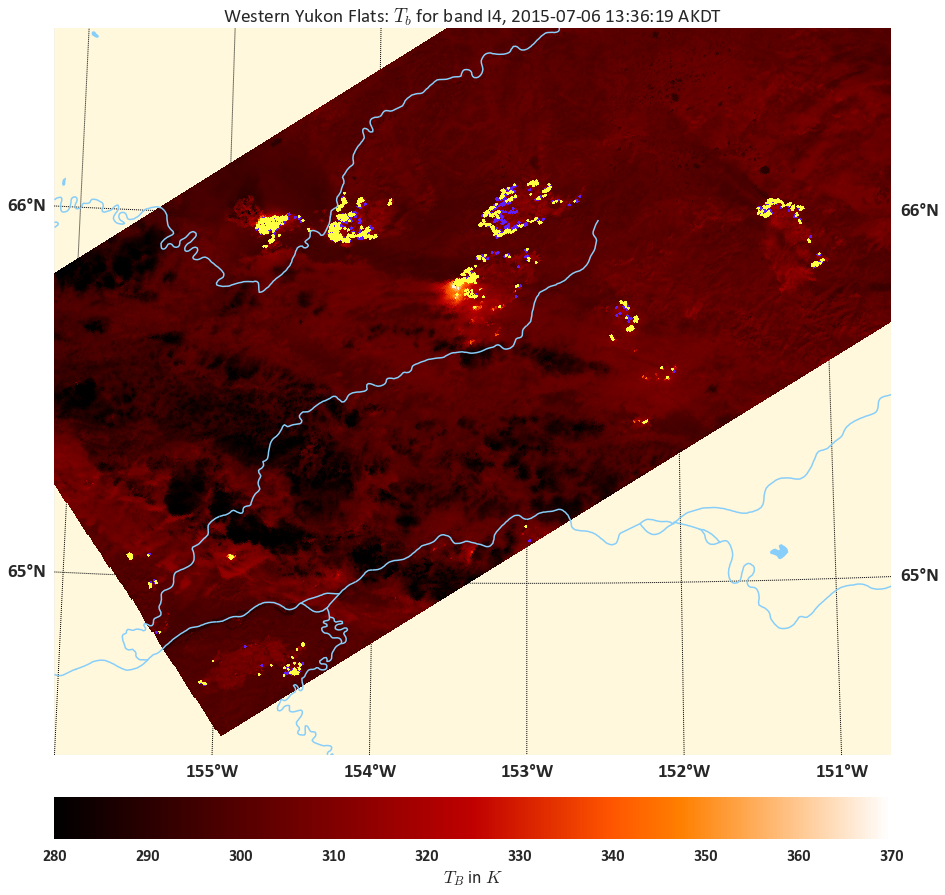

In [50]:
MASK = True
PLOTB4 = False



i4sc = raster.VIIRSHDF5(i04paths[sceneid])
i5sc = raster.VIIRSHDF5(i05paths[sceneid])
imin, imax, jmin, jmax = i4sc.crop(sample_lat, sample_lon, deli, delj)

ascendingnode = True
middlelatdelta = i4sc.lats[-1, 3200] - i4sc.lats[0, 3200]
if middlelatdelta < 0:
    ascendingnode = False 
i4sc.ascendingnode = ascendingnode
skips = vst.get_skips(i4sc, imin=imin, imax=imax, jmin=jmin, jmax=jmax)

lons = i4sc.lons[imin:imax, jmin:jmax]
lats = i4sc.lats[imin:imax, jmin:jmax]

mult, add = i4sc.I4['BrightnessTemperatureFactors'][:]
i4tb = i4sc.I4['BrightnessTemperature'][imin:imax, jmin:jmax]
plotraster4 = i4tb * mult + add
mult, add = i5sc.I5['BrightnessTemperatureFactors'][:]
i5tb = i5sc.I5['BrightnessTemperature'][imin:imax, jmin:jmax]
plotraster5 = i5tb * mult + add
pixq4 = i4sc.pixelquality[imin:imax, jmin:jmax]
pixq5 = i5sc.pixelquality[imin:imax, jmin:jmax]

plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)


datestamp = vt.getdatestamp_AKDT(i4sc)

nightscene = True
solzenithangles = i4sc.geodata['SolarZenithAngle'][imin:imax, jmin:jmax]
satazimuthangles = i4sc.geodata['SatelliteAzimuthAngle'][imin:imax, jmin:jmax]
if np.all(solzenithangles <= 90.):
    nightscene = False
elif (np.any(solzenithangles > 90.) & np.any(solzenithangles <= 90.)):
    print("WARNING: mixed scene with zenith angles above and below 90°.")

i45 =  (i4tb - i5tb) / (i4tb + i5tb)

datestamp = vt.getdatestamp_AKDT(i4sc)

# conditions
duplicatecondition = (skips == 1.)

scene = raster.VIIRSHDF5(i01paths[IDX])
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster1 = testdat*mult + add
plotraster1 = np.delete(plotraster1, excluderows, 0)

scene = raster.VIIRSHDF5(i02paths[IDX])
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster2 = testdat*mult + add
plotraster2 = np.delete(plotraster2, excluderows, 0)

cmap4 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'turquoise']))

if PLOTB4:
    titlestr1 = "Sockeye fire: $T_b$ from band I4"
else:
    titlestr1 = "Sockeye fire: Normalized difference in $T_b$ between I4 and I5"

if MASK:
    duplicatecondition = (np.delete(skips, excluderows, 0) == 1.)

    if nightscene:
        anomalouscondition = np.logical_or(
            np.logical_and(pixq4 == 193, plotraster4 < 360),
            np.logical_and(pixq5 == 0, plotraster4 == 367.))
        plotraster45_anomalousmasked = np.ma.masked_where(
            ~anomalouscondition, np.ones(plotraster45.shape))
        cloudcondition = (plotraster5 < 265.)
        hotcondition = (plotraster45 >= 0.05)
        hotcondition = np.logical_and(~cloudcondition, hotcondition)
        warmcondition = np.logical_and(~hotcondition, plotraster45 >= 0.015)
        warmcondition = np.logical_and(plotraster4 > 290, warmcondition)
        warmcondition = np.logical_and(~cloudcondition, warmcondition)
        cloudcondition = np.logical_and(
            plotraster4 < 295, plotraster5 < 265
        )

    else:
        # it's day 
        anomalouscondition = np.logical_or(
            np.logical_and(pixq4 == 193, plotraster4 < 360),
            np.logical_and(pixq5 == 0, plotraster4 == 367.))
        anomalouscondition = np.logical_and(
            ~duplicatecondition, anomalouscondition)
        
        hotcondition = (plotraster45 >= 0.05)
        hotcondition = np.logical_and(
            np.logical_and(hotcondition, plotraster4 > 320), plotraster5 > 290)
        hotcondition = np.logical_and(
            hotcondition, ~anomalouscondition)
        hotcondition = np.logical_and(
            ~duplicatecondition, hotcondition)
        
        warmcondition = ( plotraster45 >= 0.015)
        warmcondition = np.logical_and(
            warmcondition, plotraster5 > 312)
        warmcondition = np.logical_and(
            warmcondition, plotraster4 > 320)
        warmcondition = np.logical_and(
            warmcondition, ~anomalouscondition)
        warmcondition = np.logical_and(
            ~duplicatecondition, warmcondition)
 
        warmcondition = np.logical_or(
            plotraster45 >= 0.02, np.logical_and(
                plotraster45 >= 0.015, plotraster5 >= 312))
        warmcondition = np.logical_and(
            warmcondition, plotraster4 > 320)
        warmcondition = np.logical_and(
            ~duplicatecondition, warmcondition)

        cloudcondition = np.logical_or(
            plotraster5 < 265, 
            np.logical_and(plotraster1 + plotraster2 > 0.9, plotraster5 < 295))
        cloudcondition = np.logical_or(
            cloudcondition,
            np.logical_and(plotraster1 + plotraster2 > 0.7, plotraster5 < 285),)
    cloudmask = np.ma.masked_where(
        ~cloudcondition, np.ones(plotraster5.shape))
    plotraster45_masked = np.ma.masked_where(
        ~hotcondition, np.ones(plotraster45.shape))
    plotraster_cool = np.ma.masked_where(
        ~warmcondition, np.ones(plotraster45.shape))
    plotraster45_anomalousmasked = np.ma.masked_where(
        ~anomalouscondition, np.ones(plotraster45.shape))

    cmap1 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
    cmap2 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))
    cmap3 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'kelly green']))
    
    plottitle = '{}, {}\n high intensity fire pixels in bright yellow, low intensity in purple, saturated in green'.format(
        titlestr1, datestamp)
else:
    plottitle = '{}, {}'.format(titlestr1, datestamp)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

if PLOTB4:
    dataplot = ax1.pcolormesh(np.fliplr(plotraster4), vmin=280, vmax=370) 
    cbarlabel = "$T_B$ in $K$"
else:
    dataplot = ax1.pcolormesh(np.fliplr(plotraster45))   
    cbarlabel = "Normalized diff between $T_{B4}$ and $T_{B5}$ (unitless)"


if MASK:
    dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
    dataplot2 = ax1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
    dataplot4 = ax1.pcolormesh(np.fliplr(plotraster45_anomalousmasked), cmap=cmap3, vmin=0, vmax=1)
    cloudplot = ax1.pcolormesh(np.fliplr(cloudmask), cmap=cmap4, alpha=0.5, vmin=0, vmax=1)

ax1.set_title(plottitle)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()

cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label(cbarlabel)

plt.show()



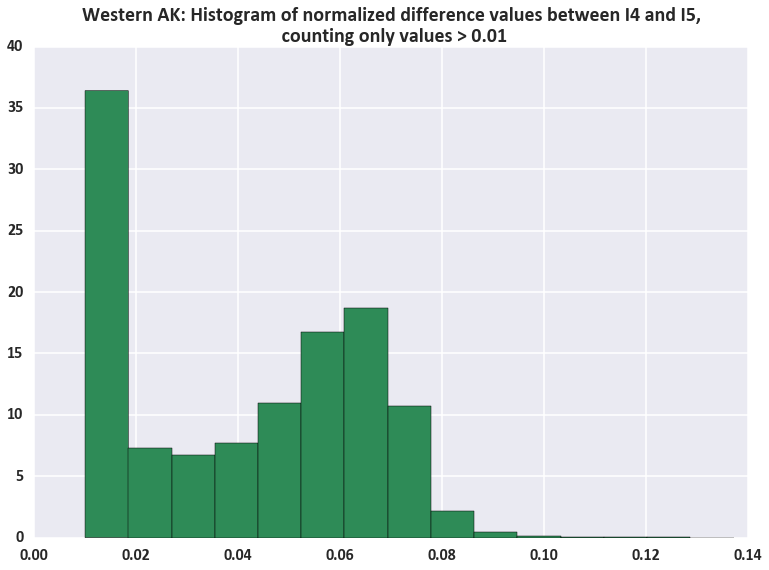

In [40]:
normdiffs = plotraster45.flatten()
values = normdiffs[normdiffs>0.01]
n, bins, patches = plt.hist(values, 15, normed=1, facecolor='seagreen') 
plt.title("Western AK: Histogram of normalized difference values between I4 and I5,\n counting only values > 0.01")

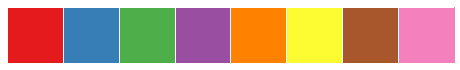

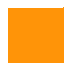

In [46]:
sns.palplot(sns.color_palette("Set1", n_colors=8))
sns.palplot(sns.xkcd_palette(['tangerine']))

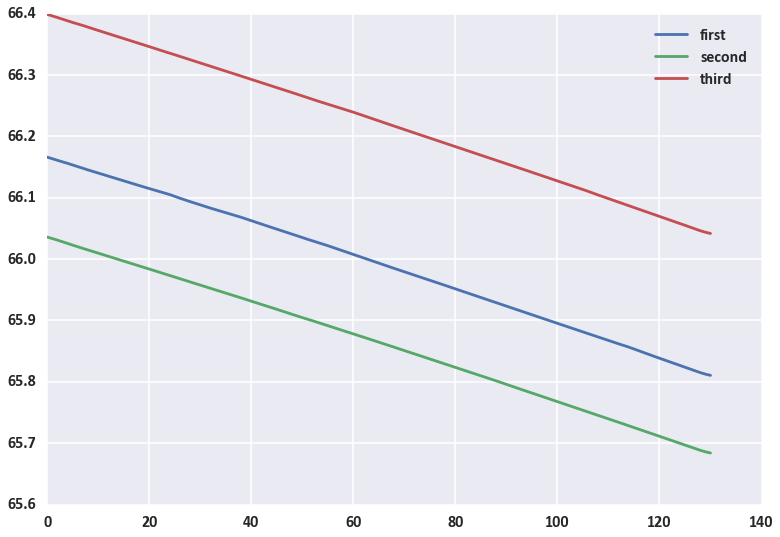

In [153]:
plt.plot(range(jmax-jmin), testscene04.lats[imin+50, jmin:jmax], label='first')
plt.plot(range(jmax-jmin), testscene04.lats[imin, jmin:jmax], label='second')
plt.plot(range(jmax-jmin), testscene04.lats[imax, jmin:jmax], label='third')
plt.legend()

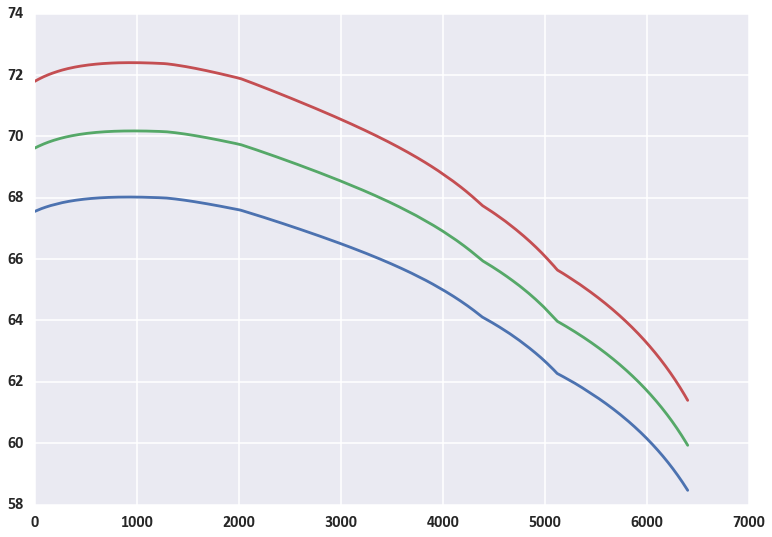

In [156]:
plt.plot(range(testscene04.lats.shape[1]), testscene04.lats[100, :])
plt.plot(range(testscene04.lats.shape[1]), testscene04.lats[testscene04.lats.shape[0]//2, :])
plt.plot(range(testscene04.lats.shape[1]), testscene04.lats[-100, :])

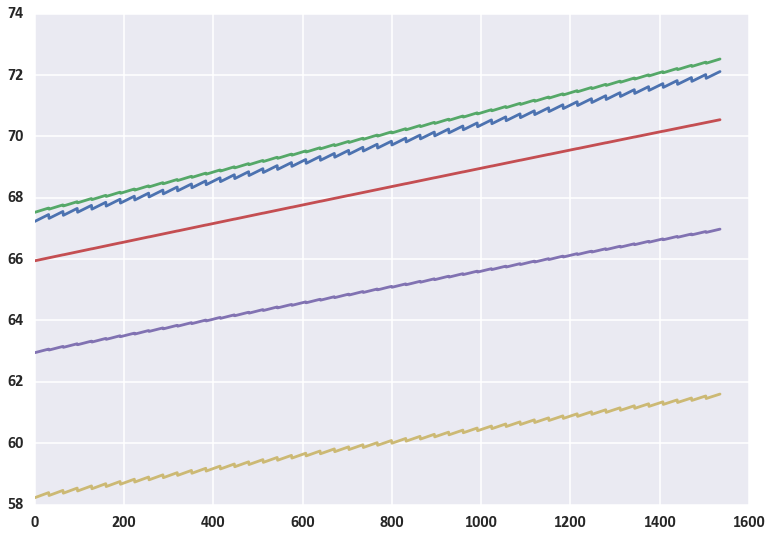

In [162]:
plt.plot(range(testscene04.lats.shape[0]), testscene04.lats[:, 1])
plt.plot(range(testscene04.lats.shape[0]), testscene04.lats[:, testscene04.lats.shape[1]//4])
plt.plot(range(testscene04.lats.shape[0]), testscene04.lats[:, testscene04.lats.shape[1]//2])
plt.plot(range(testscene04.lats.shape[0]), testscene04.lats[:, 3*testscene04.lats.shape[1]//4])
plt.plot(range(testscene04.lats.shape[0]), testscene04.lats[:, -1])

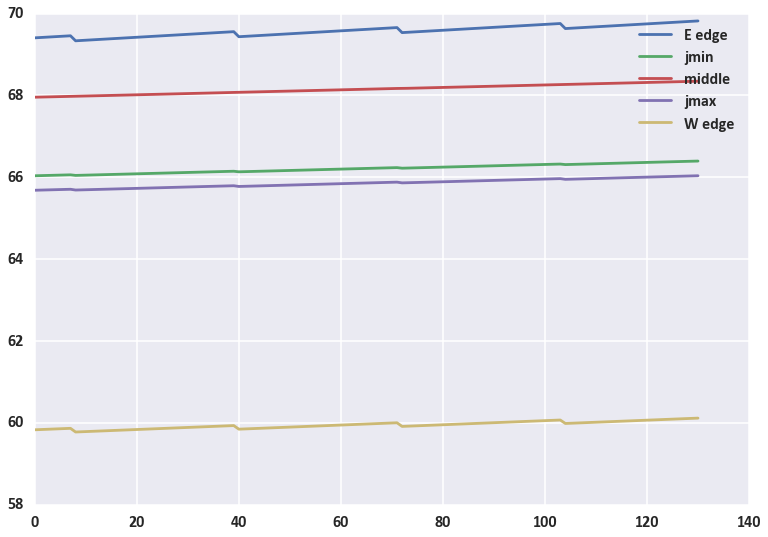

In [168]:
plt.plot(range(imax-imin), testscene04.lats[imin:imax, 10], label='E edge')
plt.plot(range(imax-imin), testscene04.lats[imin:imax, jmin], label='jmin')
plt.plot(range(imax-imin), testscene04.lats[imin:imax, testscene04.lats.shape[1]//2], label='middle')
plt.plot(range(imax-imin), testscene04.lats[imin:imax, jmax], label='jmax')
plt.plot(range(imax-imin), testscene04.lats[imin:imax, -10], label='W edge')
plt.legend()

In [166]:
jmin, jmax, testscene04.lats.shape[1]//2

(4255, 4386, 3200)